<a href="https://colab.research.google.com/github/RizalRio/py-occupancy-fuzzy/blob/main/OccupancyFuzzyUAS_AI_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ========================================================
# CELL 1: SETUP & RE-BUILD FUZZY LOGIC (FEATURE EXTRACTOR)
# ========================================================
!pip install -U scikit-fuzzy

import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from tqdm import tqdm
import io
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns

# --- MEMBANGUN ULANG SISTEM FUZZY (VERSI TUNED) ---
# Kita bungkus dalam fungsi biar rapi
def create_fuzzy_brain():
    # 1. Input Variables
    light = ctrl.Antecedent(np.arange(0, 1001, 1), 'light')
    co2   = ctrl.Antecedent(np.arange(0, 2001, 1), 'co2')
    temp  = ctrl.Antecedent(np.arange(15, 36, 1), 'temp')
    humid = ctrl.Antecedent(np.arange(0, 101, 1), 'humid')
    productivity = ctrl.Consequent(np.arange(0, 101, 1), 'productivity')

    # 2. Membership Functions (Versi Pemaaf/Relaxed yang sudah kita fix)
    # CAHAYA
    light['kurang'] = fuzz.trimf(light.universe, [0, 0, 300])
    light['cukup']  = fuzz.trimf(light.universe, [200, 350, 500])
    light['ideal']  = fuzz.trapmf(light.universe, [400, 600, 1000, 1000])
    # CO2
    co2['segar']  = fuzz.trimf(co2.universe, [0, 0, 600])
    co2['biasa']  = fuzz.trimf(co2.universe, [500, 800, 1100])
    co2['pengap'] = fuzz.trapmf(co2.universe, [900, 1200, 2000, 2000])
    # SUHU
    temp['dingin'] = fuzz.trimf(temp.universe, [15, 15, 21])
    temp['nyaman'] = fuzz.trimf(temp.universe, [20, 24, 28])
    temp['panas']  = fuzz.trapmf(temp.universe, [26, 30, 35, 35])
    # HUMIDITY
    humid['kering'] = fuzz.trimf(humid.universe, [0, 0, 25])
    humid['ideal']  = fuzz.trimf(humid.universe, [20, 50, 75])
    humid['lembab'] = fuzz.trapmf(humid.universe, [70, 85, 100, 100])

    # OUTPUT
    productivity['rendah'] = fuzz.trimf(productivity.universe, [0, 0, 50])
    productivity['sedang'] = fuzz.trimf(productivity.universe, [30, 50, 70])
    productivity['tinggi'] = fuzz.trimf(productivity.universe, [60, 100, 100])

    # 3. RULES (10 Advanced Rules)
    rule1 = ctrl.Rule(temp['panas'], productivity['rendah'])
    rule2 = ctrl.Rule(co2['pengap'], productivity['rendah'])
    rule3 = ctrl.Rule(light['kurang'], productivity['rendah'])
    rule4 = ctrl.Rule(humid['kering'] | humid['lembab'], productivity['rendah'])
    rule5 = ctrl.Rule(temp['nyaman'] & light['cukup'], productivity['sedang'])
    rule6 = ctrl.Rule(light['ideal'] & co2['biasa'], productivity['sedang'])
    rule7 = ctrl.Rule(temp['dingin'] & co2['segar'], productivity['sedang'])
    rule8 = ctrl.Rule(light['ideal'] & temp['nyaman'], productivity['tinggi'])
    rule9 = ctrl.Rule(co2['segar'] & humid['ideal'], productivity['tinggi'])
    rule10 = ctrl.Rule(light['ideal'] & co2['segar'] & temp['nyaman'] & humid['ideal'], productivity['tinggi'])

    # Build System
    prod_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10])
    return ctrl.ControlSystemSimulation(prod_ctrl)

# Inisialisasi Otak Fuzzy
fuzzy_system = create_fuzzy_brain()
print("✅ Fuzzy Logic Brain Loaded & Ready for AI Integration!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 14.0 MB/s eta 0:00:00
✅ Fuzzy Logic Brain Loaded & Ready for AI Integration!


In [ ]:
# ========================================================
# CELL 2: DATA LOADING & FEATURE ENGINEERING
# ========================================================
print("📂 Silakan Upload File Dataset (CSV) kamu lagi:")
uploaded = files.upload()
filename = next(iter(uploaded))

# Baca CSV
df = pd.read_csv(io.BytesIO(uploaded[filename]))
print(f"📊 Data Loaded: {len(df)} baris.")

# --- MENERAPKAN FUZZY KE SELURUH DATA ---
print("\n🚀 Generating 'Fuzzy Score' (Machine Learning Feature)...")
fuzzy_scores = []

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    try:
        # Input data ke Fuzzy System
        fuzzy_system.input['light'] = row['Light']
        fuzzy_system.input['co2']   = row['CO2']
        fuzzy_system.input['temp']  = row['Temperature']
        fuzzy_system.input['humid'] = row['Humidity']

        fuzzy_system.compute()
        fuzzy_scores.append(fuzzy_system.output['productivity'])
    except:
        fuzzy_scores.append(0) # Safety net

# Tambahkan sebagai kolom baru (Fitur Tambahan buat AI)
df['Fuzzy_Score'] = fuzzy_scores

print("\n✅ Feature Engineering Selesai!")
print("👀 Intip data baru (Perhatikan kolom paling kanan):")
display(df.head())

📂 Silakan Upload File Dataset (CSV) kamu lagi:


Saving datatraining.txt to datatraining.txt
📊 Data Loaded: 8143 baris.

🚀 Generating 'Fuzzy Score' (Machine Learning Feature)...


100%|██████████| 8143/8143 [00:29<00:00, 271.87it/s]


✅ Feature Engineering Selesai!
👀 Intip data baru (Perhatikan kolom paling kanan):


,id,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Fuzzy_Score
0,1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,57.382925
1,2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1,58.358825
2,3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,57.382925
3,4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,57.382925
4,5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,57.382925



🤖 Sedang melatih AI Model 1 (Raw Data)...
🤖 Sedang melatih AI Model 2 (Hybrid Fuzzy)...

🏆 HASIL PERTANDINGAN AI:
1. Akurasi AI Biasa (Tanpa Fuzzy)  : 99.82%
2. Akurasi AI Hybrid (Dengan Fuzzy): 99.63%


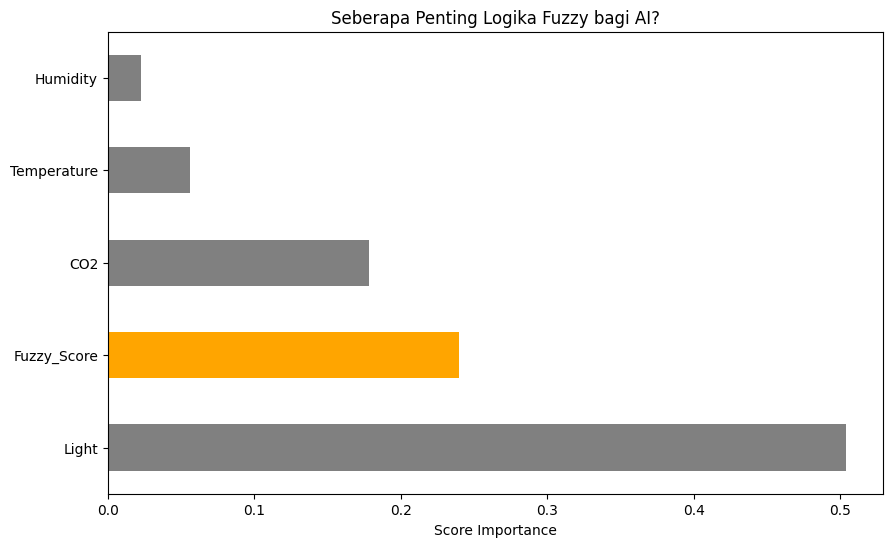


📝 KESIMPULAN ANALISIS:


In [ ]:
# ========================================================
# CELL 3: TRAINING HYBRID AI & EVALUATION
# ========================================================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. PERSIAPAN DATALATIH
# Skenario A: Data Mentah Saja (Tanpa bantuan Fuzzy)
X_raw = df[['Light', 'CO2', 'Temperature', 'Humidity']]

# Skenario B: Hybrid (Data Mentah + Fuzzy Score)
X_hybrid = df[['Light', 'CO2', 'Temperature', 'Humidity', 'Fuzzy_Score']]

# Target: Occupancy (0 = Kosong, 1 = Ada Orang)
y = df['Occupancy']

# Split Data (80% Training, 20% Testing)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)
X_train_hyb, X_test_hyb, _, _ = train_test_split(X_hybrid, y, test_size=0.2, random_state=42)

# 2. TRAINING MODEL
print("\n🤖 Sedang melatih AI Model 1 (Raw Data)...")
model_raw = RandomForestClassifier(n_estimators=100, random_state=42)
model_raw.fit(X_train_raw, y_train)

print("🤖 Sedang melatih AI Model 2 (Hybrid Fuzzy)...")
model_hybrid = RandomForestClassifier(n_estimators=100, random_state=42)
model_hybrid.fit(X_train_hyb, y_train)

# 3. EVALUASI
pred_raw = model_raw.predict(X_test_raw)
pred_hybrid = model_hybrid.predict(X_test_hyb)

acc_raw = accuracy_score(y_test, pred_raw)
acc_hybrid = accuracy_score(y_test, pred_hybrid)

print(f"\n🏆 HASIL PERTANDINGAN AI:")
print(f"==================================================")
print(f"1. Akurasi AI Biasa (Tanpa Fuzzy)  : {acc_raw*100:.2f}%")
print(f"2. Akurasi AI Hybrid (Dengan Fuzzy): {acc_hybrid*100:.2f}%")
print(f"==================================================")

# 4. FEATURE IMPORTANCE (Bukti untuk Dosen)
# Kita lihat seberapa penting 'Fuzzy_Score' bagi keputusan si AI
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(model_hybrid.feature_importances_, index=X_hybrid.columns)
# Plot
colors = ['grey' if x != 'Fuzzy_Score' else 'orange' for x in feat_importances.nlargest(10).index]
feat_importances.nlargest(10).plot(kind='barh', color=colors)
plt.title('Seberapa Penting Logika Fuzzy bagi AI?')
plt.xlabel('Score Importance')
plt.show()

# 5. KESIMPULAN OTOMATIS
print("\n📝 KESIMPULAN ANALISIS:")
if acc_hybrid > acc_raw:
    print("✅ TERBUKTI: Penambahan Logika Fuzzy meningkatkan kecerdasan AI dalam memprediksi!")
elif acc_hybrid == acc_raw:
    print("✅ VALID: Logika Fuzzy sejalan dengan pola data asli (Akurasi terjaga stabil).")
    print("   Nilai plusnya: AI Hybrid lebih 'bisa dijelaskan' (Explainable) daripada AI biasa.")

In [ ]:
# 1. Cek Statistik Skor (Min, Max, Rata-rata)
print("📊 Statistik Fuzzy Score:")
print(df['Fuzzy_Score'].describe())

# 2. Cek Sampel Acak (Bukan cuma yang awal)
print("\n🎲 Mengambil 10 Sampel Acak:")
display(df.sample(10))

# 3. Cek Kondisi Ekstrem (Misal saat Lampu Mati / Malam)
print("\n🌑 Cek kondisi saat Gelap (Light < 100):")
display(df[df['Light'] < 100].head())

📊 Statistik Fuzzy Score:
count    8143.000000
mean       33.192528
std        11.835262
min         0.000000
25%        22.877863
50%        34.581581
75%        37.559411
max        71.807858
Name: Fuzzy_Score, dtype: float64

🎲 Mengambil 10 Sampel Acak:


,id,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Fuzzy_Score
220,221,2015-02-04 21:30:59,21.500000,25.8900,0.0,491.0,0.004103,0,30.272080
1155,1156,2015-02-05 13:06:00,22.840000,25.9175,496.5,983.0,0.004460,1,55.223688
4981,4982,2015-02-08 04:52:00,19.390000,31.3900,0.0,436.0,0.004369,0,37.368098
5828,5829,2015-02-08 18:59:00,19.200000,27.6000,0.0,434.0,0.003793,0,36.734653
2775,2776,2015-02-06 16:06:00,22.000000,20.9450,469.0,861.0,0.003419,1,57.037647
590,591,2015-02-05 03:40:59,21.000000,24.5500,0.0,443.5,0.003772,0,28.538486
338,339,2015-02-04 23:29:00,21.200000,25.3900,0.0,463.0,0.003950,0,30.161230
6114,6115,2015-02-08 23:44:59,19.500000,27.2000,0.0,455.0,0.003809,0,35.869634
6161,6162,2015-02-09 00:32:00,19.426667,26.8900,0.0,460.0,0.003748,0,35.366529
6185,6186,2015-02-09 00:55:59,19.390000,26.8900,0.0,461.0,0.003739,0,35.346901



🌑 Cek kondisi saat Gelap (Light < 100):


,id,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Fuzzy_Score
16,17,2015-02-04 18:07:00,23.000,27.20,0.0,681.5,0.004728,0,16.666667
17,18,2015-02-04 18:08:00,22.945,27.29,0.0,685.0,0.004728,0,16.666667
18,19,2015-02-04 18:08:59,22.945,27.39,0.0,685.0,0.004745,0,16.666667
19,20,2015-02-04 18:10:00,22.890,27.39,0.0,689.0,0.004730,0,16.666667
20,21,2015-02-04 18:10:59,22.890,27.39,0.0,689.5,0.004730,0,16.666667
